In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
sns.set()
import datetime
import os
from tqdm import *
from pathlib import Path
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import math
from IPython.display import display_html

import statsmodels.formula.api
import statsmodels.api

import warnings
warnings.filterwarnings('ignore')


%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
df=pd.read_csv('df_simul.csv')
df.head(2)

,customer_unique_id,Recency,Frequency,Monetary,order_purchase_timestamp,review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,110,1,141.90,2018-05-10 10:56:27,5
1,0000b849f77a49e4a4ce2b2a4ca5be3f,113,1,27.19,2018-05-07 11:11:27,4


In [3]:
print("Date du dernier achat", df.order_purchase_timestamp.max())
print("Date du premier achat", df.order_purchase_timestamp.min())

Date du dernier achat 2018-08-29 15:00:37
Date du premier achat 2016-10-03 09:44:50


In [4]:
df.order_purchase_timestamp = df.order_purchase_timestamp.apply(pd.to_datetime, format='%Y-%m-%d')

In [5]:
df.order_purchase_timestamp = df.order_purchase_timestamp.apply(lambda x: x.date())

In [6]:
from pandas.tseries.offsets import DateOffset
df0 = df[df.order_purchase_timestamp <= (df.order_purchase_timestamp.min() + DateOffset(years=1))]

In [7]:
df0

,customer_unique_id,Recency,Frequency,Monetary,order_purchase_timestamp,review_score
2,0000f46a3911fa3c0805444483337064,536,1,86.22,2017-03-10,3
8,0005e1862207bf6ccc02e4228effd9a0,542,1,150.12,2017-03-04,4
10,0006fdc98a402fceb4eb0ee528f6a8d4,406,1,29.00,2017-07-18,3
14,000a5ad9c4601d2bbdd9ed765d5213b3,382,1,91.28,2017-08-11,4
15,000bfa1d2f1a41876493be685390d6d3,333,1,46.85,2017-09-29,5
...,...,...,...,...,...,...
94475,fff3a9369e4b7102fab406a334a678c3,382,1,102.74,2017-08-11,5
94478,fff699c184bcc967d62fa2c6171765f7,361,1,55.00,2017-09-01,4
94483,fffcf5a5ff07b0908bd4e2dbc735a684,446,1,2067.42,2017-06-08,5
94485,ffff371b4d645b6ecea244b27531430a,567,1,112.46,2017-02-07,5


In [8]:
from sklearn import decomposition
df0 = df.drop(["order_purchase_timestamp","customer_unique_id"], axis = 1)

#standardisation
ss = StandardScaler()
df0_scaled = pd.DataFrame(data= ss.fit_transform(df0), columns = df0.columns)

#analyse en composantes principales pour réduction
pca0 = decomposition.PCA(random_state = 42)
pca0.fit(df0_scaled)
projected0 = pca0.transform(df0_scaled)

#on récupère les 3 eres composantes principales
df0_scaled["PC1"] =projected0[:,0]
df0_scaled["PC2"] = projected0[:,1]
df0_scaled["PC3"] = projected0[:,2]
    
df0_pca0 = df0_scaled[['PC1','PC2', 'PC3']]

In [9]:
def calc_period(data, nbdays):
    '''
    Fonction qui crée un dataframe avec 1 an + nbdays de données
        Paramètre : 
            data : dataframe 
            nbdays : entier, nombre de jours à ajouter à 365 jours
        Sortie : Dataframe de données sur l'intervalle de temps voulu
        
    '''
    return data[data.order_purchase_timestamp <= (data.order_purchase_timestamp.min() + DateOffset(days=365+nbdays))]

In [10]:
def std_pca_data(df):
    '''
    Fonction qui standardise puis réalise une ACP et réduis à 3 composantes un Dataframe
        Paramètres : 
            df : Dataframe 
        Sortie : 
            Dataframe standardisé et projeté sur ses 3 premières composantes principales 
    '''
    df = df.drop("order_purchase_timestamp", axis = 1)
    #standardisation
    ss = StandardScaler()
    df_scaled = pd.DataFrame(data= ss.fit_transform(df), columns = df.columns)
    #analyse en composantes principales pour réduction
    pca = decomposition.PCA(random_state = 42)
    pca.fit(df_scaled)
    projected = pca.transform(df_scaled)
    #on récupère les 3 eres composantes principales
    df_projected = pd.DataFrame()
    df_projected["PC1"] =projected[:,0]
    df_projected["PC2"] = projected[:,1]
    df_projected["PC3"] = projected[:,2]
    
    #df_pca = df_scaled[['PC1','PC2', 'PC3']]
    
    return   df_projected, df_scaled   

In [11]:
def calcKmeans(df_pca): 
    '''
    Applique la segmentation K-means sur un dataframe
    
        Paramètres : 
            df_pca: dataframe (réduis avec ACP idéalement) à segmenter
        Sortie : 
            Liste des clusters calculés
    '''
    kmeans = KMeans(n_clusters = 4).fit(df_pca)
    #clusters = kmeans.predict(df_pca)
    cluster_labels = kmeans.labels_
    df_pca_km = df_pca.assign(Cluster = cluster_labels)
    return  cluster_labels

In [12]:
df = df.drop(["customer_unique_id"], axis = 1)

ari_score = []
for i in range(0,60,5):
    
    df_projected_i, df_scaled_i = std_pca_data(calc_period(df, i))

    #On applique la PCA initiale sur la nouvelle période
    projected_i0 = pca0.transform(df_scaled_i)
    #on récupère les 3 eres composantes principales
    df_projected_i0 = pd.DataFrame()
    df_projected_i0["PC1"] =projected_i0[:,0]
    df_projected_i0["PC2"] = projected_i0[:,1]
    df_projected_i0["PC3"] = projected_i0[:,2]
    
    #df_pca_k0 = df_scaled_k[['PC1','PC2', 'PC3']]
    ari_i = adjusted_rand_score(calcKmeans(df_projected_i0),calcKmeans(df_projected_i))
    
    ari_score.append([i,ari_i])

In [13]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"] )
ari_score

,periode,ARI
0,0,0.442450
1,5,0.440971
2,10,0.439648
3,15,0.436181
4,20,0.434841
5,25,0.432026
6,30,0.846181
7,35,0.850017
8,40,0.861178
9,45,0.868516


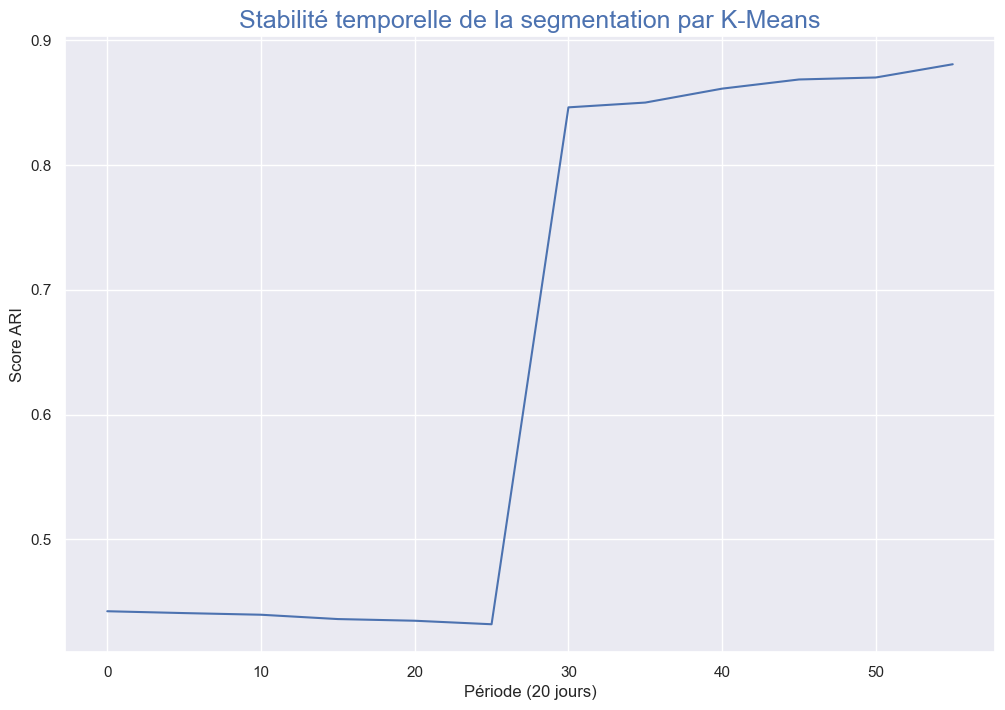

In [14]:
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")

plt.xlabel("Période (10 jours)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()